In [1]:
# libraries
import os
import sys
import json
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../../extra_files'))
import helper as hp
from imageio import imwrite, imread
from skimage.transform import resize

In [2]:
# File paths
data_path = '/home/aldo/Documents/data-cic/'
preprocess_path = data_path + 'preprocess_data'

## Training SSD300 trained with mobilenet backbone trained

In [3]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from light_models.keras_ssd300_mobilenetv1 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

from extra_files.f1_callback import F1_callback as f1_call

Using TensorFlow backend.
/home/aldo/Documents/ssd/data_generator/object_detection_2d_data_generator.py:43: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")


### Parameters (original SSD300 architecture)

In [4]:
## Parameteres needed for ssd_300() and SSDInputEncoder()

img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [1., 1., 1.] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
divide_by_stddev = [127.5, 127.5, 127.5]
swap_channels = False # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales = scales_pascal
#scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [16, 30, 60, 100, 150, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

## Create new model with SSD weights

In [5]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                alpha=0.75,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

# 2: Load some weights into the model.

# TODO: Set the path to the weights you want to load.
#weights_path = '/home/aldo/Documents/weights/classifiers/mobilenetv1_alpha_0.75.h5'
#weights_path = '/home/aldo/Downloads/ssd300_mobilenetv1_imagenet_cic.h5'
#model.load_weights(weights_path, by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

adam = Adam(lr=0.001)
#sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [6]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_stddev_normalization (Lam (None, 300, 300, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 300, 3)  0           input_stddev_normalization[0][0] 
__________________________________________________________________________________________________
model_1 (M

## Data generator for the training

In [7]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your dataset here.

# Images
images_dir = data_path + 'PASCAL'
#images_dir = data_path + 'COCO'

# Ground truth
#train_labels_filename = preprocess_path + '/PASCAL_train.csv'
train_labels_filename = preprocess_path + '/PASCAL_train_val.csv'
val_labels_filename   = preprocess_path + '/PASCAL_val.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(#images_dir=images_dir,
                      data_path + 'PASCAL',
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading images into memory: 100%|██████████| 1025/1025 [00:04<00:00, 220.21it/s]
Number of images in the training dataset:	  6469
Number of images in the validation dataset:	  1025


In [8]:
# 3: Set the batch size.
batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.
# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=(0, 0, 0))

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.
# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv11_mbox_conf').output_shape[1:3],
                   model.get_layer('conv13_mbox_conf').output_shape[1:3],
                   model.get_layer('conv14_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv15_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv16_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv17_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         #transformations=[convert_to_3_channels,
                                                          #resize],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	  6469
Number of images in the validation dataset:	  1025


## Remaining training parameters

In [10]:
# Define a learning rate schedule.
def lr_schedule(epoch):
    if epoch < 60:
        return 0.001
    elif epoch < 70:
        return 0.0001
    else:
        return 0.00001

In [9]:
lr_list = [0.01, 0.001, 0.0001]

for lr in lr_list:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH LEARNING RATE:', lr)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                alpha=0.75,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=lr)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Downloads/mobilenetv1'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'model_' + str(lr) + '.csv',
                           separator=',',
                           append=True)


    f1_callback = f1_call(0.20, 
                           0.45, 
                           200, 
                           normalize_coords, 
                           img_height, 
                           img_width, 
                           (1, 2006, 14),
                           main_path + 'f1_' + str(lr) + '.csv',
                           main_path + 'model.h5',
                           label_csv='/home/aldo/Documents/data-cic/preprocess_data/PASCAL_val.csv',
                           path_img='/home/aldo/Documents/data-cic/PASCAL',
                           verborse=True)


    callbacks = [csv_logger,
                 f1_callback]
    
    initial_epoch   = 0
    final_epoch     = 100
    steps_per_epoch = 200

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  validation_data=val_generator,
                                  validation_steps=ceil(val_dataset_size/batch_size),
                                  initial_epoch=initial_epoch)

TRAINING MODEL WITH LEARNING RATE: 0.01
Epoch 1/100
200/200 [==============================] - 142s 711ms/step - loss: 111.7900 - val_loss: 90.4159


/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:383: RuntimeWarning: invalid value encountered in true_divide
  return intersection_areas / union_areas
/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:91: RuntimeWarning: invalid value encountered in less_equal
  boxes_left = boxes_left[similarities <= iou_threshold] # ...so that we can remove the ones that overlap too much with the maximum box


Number of images: 1025
Presicion: 0.0263
Recall: 0.3561
F1 score: 0.0489
F1 score: 0.04894095595211401
Improve F1 score from -inf to 0.04894095595211401
Epoch 2/100
200/200 [==============================] - 139s 694ms/step - loss: 106.4814 - val_loss: 76.7711
Number of images: 1025
Presicion: 0.032
Recall: 0.3459
F1 score: 0.0585
F1 score: 0.05854565990737442
Improve F1 score from 0.04894095595211401 to 0.05854565990737442
Epoch 3/100
200/200 [==============================] - 139s 694ms/step - loss: 106.5777 - val_loss: 110.3970
Number of images: 1025
Presicion: 0.0395
Recall: 0.3449
F1 score: 0.0708
F1 score: 0.07081052497917206
Improve F1 score from 0.05854565990737442 to 0.07081052497917206
Epoch 4/100
200/200 [==============================] - 134s 671ms/step - loss: 112.8524 - val_loss: 136.9097
Number of images: 1025
Presicion: 0.0169
Recall: 0.2854
F1 score: 0.0318
F1 score: 0.03183358697922842
Epoch 5/100
200/200 [==============================] - 138s 692ms/step - loss: 106.

200/200 [==============================] - 108s 540ms/step - loss: 9.0756 - val_loss: 11.1659
Number of images: 1025
Presicion: 0.0454
Recall: 0.4061
F1 score: 0.0817
F1 score: 0.08171507905978873
Epoch 78/100
200/200 [==============================] - 109s 544ms/step - loss: 5.4928 - val_loss: 5.3548
Number of images: 1025
Presicion: 0.0525
Recall: 0.4296
F1 score: 0.0936
F1 score: 0.09362552099311337
Epoch 79/100
200/200 [==============================] - 109s 547ms/step - loss: 5.3425 - val_loss: 5.2209
Number of images: 1025
Presicion: 0.0445
Recall: 0.4046
F1 score: 0.0802
F1 score: 0.08018949327446166
Epoch 80/100
200/200 [==============================] - 109s 544ms/step - loss: 5.6061 - val_loss: 5.3276
Number of images: 1025
Presicion: 0.0203
Recall: 0.3338
F1 score: 0.0382
F1 score: 0.03824976237291126
Epoch 81/100
200/200 [==============================] - 108s 541ms/step - loss: 5.3515 - val_loss: 5.1436
Number of images: 1025
Presicion: 0.0222
Recall: 0.3587
F1 score: 0.04

200/200 [==============================] - 108s 542ms/step - loss: 4.6643 - val_loss: 4.7686
Number of images: 1025
Presicion: 0.0481
Recall: 0.5111
F1 score: 0.088
F1 score: 0.08796770219053482
Epoch 17/100
200/200 [==============================] - 109s 545ms/step - loss: 4.6562 - val_loss: 4.7102
Number of images: 1025
Presicion: 0.0631
Recall: 0.5089
F1 score: 0.1122
F1 score: 0.1122478043795994
Epoch 18/100
200/200 [==============================] - 108s 539ms/step - loss: 5.0247 - val_loss: 4.9918
Number of images: 1025
Presicion: 0.038
Recall: 0.4494
F1 score: 0.0701
F1 score: 0.07008603931852116
Epoch 19/100
200/200 [==============================] - 108s 539ms/step - loss: 4.6997 - val_loss: 4.7310
Number of images: 1025
Presicion: 0.0489
Recall: 0.5004
F1 score: 0.0892
F1 score: 0.08916429201746243
Epoch 20/100
200/200 [==============================] - 109s 543ms/step - loss: 4.7086 - val_loss: 4.8220
Number of images: 1025
Presicion: 0.0433
Recall: 0.481
F1 score: 0.0795
F1

Epoch 55/100
200/200 [==============================] - 104s 520ms/step - loss: 4.1076 - val_loss: 4.2998
Number of images: 1025
Presicion: 0.0435
Recall: 0.5503
F1 score: 0.0807
F1 score: 0.08069754407956564
Epoch 56/100
200/200 [==============================] - 106s 530ms/step - loss: 4.0769 - val_loss: 4.1650
Number of images: 1025
Presicion: 0.0424
Recall: 0.5552
F1 score: 0.0788
F1 score: 0.07878121578552016
Epoch 57/100
200/200 [==============================] - 108s 542ms/step - loss: 4.0711 - val_loss: 4.2048
Number of images: 1025
Presicion: 0.0652
Recall: 0.5455
F1 score: 0.1165
F1 score: 0.1164721782833772
Epoch 58/100
200/200 [==============================] - 107s 537ms/step - loss: 4.1186 - val_loss: 4.1426
Number of images: 1025
Presicion: 0.0576
Recall: 0.5651
F1 score: 0.1045
F1 score: 0.10453028284451883
Epoch 59/100
200/200 [==============================] - 105s 523ms/step - loss: 4.0936 - val_loss: 4.2617
Number of images: 1025
Presicion: 0.0704
Recall: 0.5418
F1 

Number of images: 1025
Presicion: 0.346
Recall: 0.4247
F1 score: 0.3813
F1 score: 0.3813055809514358
Improve F1 score from 0.3633144671840193 to 0.3813055809514358
Epoch 94/100
200/200 [==============================] - 107s 535ms/step - loss: 3.7871 - val_loss: 3.8735
Number of images: 1025
Presicion: 0.3279
Recall: 0.4448
F1 score: 0.3775
F1 score: 0.3774761498476344
Epoch 95/100
200/200 [==============================] - 108s 541ms/step - loss: 3.7967 - val_loss: 3.8560
Number of images: 1025
Presicion: 0.244
Recall: 0.4919
F1 score: 0.3262
F1 score: 0.3262016086332068
Epoch 96/100
200/200 [==============================] - 106s 531ms/step - loss: 3.7661 - val_loss: 3.8220
Number of images: 1025
Presicion: 0.3584
Recall: 0.4467
F1 score: 0.3977
F1 score: 0.3976745546186805
Improve F1 score from 0.3813055809514358 to 0.3976745546186805
Epoch 97/100
200/200 [==============================] - 107s 536ms/step - loss: 3.7822 - val_loss: 3.9023
Number of images: 1025
Presicion: 0.3901
Rec

200/200 [==============================] - 108s 538ms/step - loss: 4.3075 - val_loss: 4.3848
Number of images: 1025
Presicion: 0.0513
Recall: 0.542
F1 score: 0.0938
F1 score: 0.0938015753032129
Epoch 71/100
200/200 [==============================] - 109s 543ms/step - loss: 4.3078 - val_loss: 4.3821
Number of images: 1025
Presicion: 0.0489
Recall: 0.5419
F1 score: 0.0897
F1 score: 0.08969171717731662
Epoch 72/100
200/200 [==============================] - 108s 540ms/step - loss: 4.3057 - val_loss: 4.3456
Number of images: 1025
Presicion: 0.0556
Recall: 0.5506
F1 score: 0.1011
F1 score: 0.10105900841892902
Epoch 73/100
200/200 [==============================] - 109s 544ms/step - loss: 4.3211 - val_loss: 4.3452
Number of images: 1025
Presicion: 0.0512
Recall: 0.55
F1 score: 0.0937
F1 score: 0.09369818179948995
Epoch 74/100
200/200 [==============================] - 107s 536ms/step - loss: 4.2848 - val_loss: 4.3639
Number of images: 1025
Presicion: 0.055
Recall: 0.546
F1 score: 0.0999
F1 s

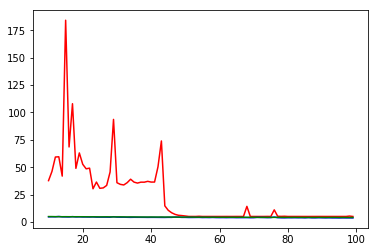

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
mob_01 = pd.read_csv(main_path + 'model_0.01.csv')
mob_001 = pd.read_csv(main_path + 'model_0.001.csv')
mob_0001 = pd.read_csv(main_path + 'model_0.0001.csv')

fig, ax = plt.subplots()
ax.plot(mob_01['epoch'][10:], mob_01['val_loss'][10:], color='r')
ax.plot(mob_001['epoch'][10:], mob_001['val_loss'][10:], color='b')
ax.plot(mob_0001['epoch'][10:], mob_0001['val_loss'][10:], color='g')

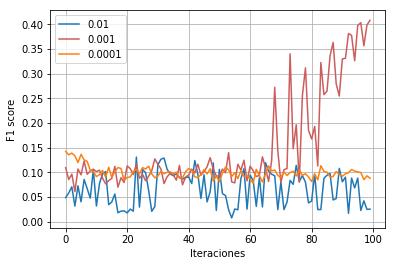

In [17]:
mob_01_f1 = pd.read_csv(main_path + 'mobilenetv1f1_0.01.csv')
mob_001_f1 = pd.read_csv(main_path + 'mobilenetv1f1_0.001.csv')
mob_0001_f1 = pd.read_csv(main_path + 'mobilenetv1f1_0.0001.csv')

fig, ax = plt.subplots()
ax.plot(mob_01_f1['epoch'], mob_01_f1['f1 score'], label='0.01')
ax.plot(mob_001_f1['epoch'], mob_001_f1['f1 score'], color='indianred', label='0.001')
ax.plot(mob_0001_f1['epoch'], mob_0001_f1['f1 score'], label='0.0001')

plt.grid(True)
plt.xlabel('Iteraciones')
plt.ylabel('F1 score')
plt.legend(loc='upper left')
plt.savefig('mejor_tasa.pdf')

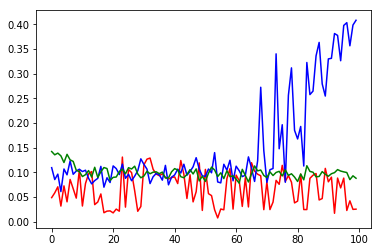

In [11]:
mob_01_f1 = pd.read_csv(main_path + 'f1_0.01.csv')
mob_001_f1 = pd.read_csv(main_path + 'f1_0.001.csv')
mob_0001_f1 = pd.read_csv(main_path + 'f1_0.0001.csv')

fig, ax = plt.subplots()
ax.plot(mob_01_f1['epoch'], mob_01_f1['f1 score'], color='r')
ax.plot(mob_001_f1['epoch'], mob_001_f1['f1 score'], color='b')
ax.plot(mob_0001_f1['epoch'], mob_0001_f1['f1 score'], color='g')

In [11]:
alphas = [0.75, 0.5, 0.25]

for alpha in alphas:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH ALPHA:', alpha)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                alpha=alpha,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=0.001)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Documents/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'data-cic/history/light_models/PASCAL/mobilenet_v1_alpha_' + str(alpha) + '.csv',
                           separator=',',
                           append=True)

    learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule, verbose=1)


    callbacks = [csv_logger,
                 learning_rate_scheduler]
    
    initial_epoch   = 0
    final_epoch     = 80
    steps_per_epoch = 1000

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  initial_epoch=initial_epoch)
    
    model.save(main_path + 'weights/light_models/PASCAL/mobilenet_v1_alpha_' + str(alpha) + '.h5')

TRAINING MODEL WITH ALPHA: 0.75
Epoch 1/80

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 577s 577ms/step - loss: 5.6219
Epoch 2/80

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 552s 552ms/step - loss: 4.9628
Epoch 3/80

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 554s 554ms/step - loss: 4.7952
Epoch 4/80

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 551s 551ms/step - loss: 4.6797
Epoch 5/80

Epoch 00005: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 551s 551ms/step - loss: 4.5091
Epoch 6/80

Epoch 00006: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 550s 550ms/step - loss: 4.3912
Epoch 7/80

Epoch 00007: LearningRateS

1000/1000 [==============================] - 550s 550ms/step - loss: 3.2275
Epoch 54/80

Epoch 00054: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 551s 551ms/step - loss: 3.2031
Epoch 55/80

Epoch 00055: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 550s 550ms/step - loss: 3.2085
Epoch 56/80

Epoch 00056: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 551s 551ms/step - loss: 3.1885
Epoch 57/80

Epoch 00057: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 552s 552ms/step - loss: 3.2010
Epoch 58/80

Epoch 00058: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 553s 553ms/step - loss: 3.1947
Epoch 59/80

Epoch 00059: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 552s 552ms/step - l

Epoch 78/80

Epoch 00078: LearningRateScheduler setting learning rate to 1e-05.
1000/1000 [==============================] - 543s 543ms/step - loss: 3.1263
Epoch 79/80

Epoch 00079: LearningRateScheduler setting learning rate to 1e-05.
1000/1000 [==============================] - 545s 545ms/step - loss: 3.1224
Epoch 80/80

Epoch 00080: LearningRateScheduler setting learning rate to 1e-05.
1000/1000 [==============================] - 540s 540ms/step - loss: 3.1137
TRAINING MODEL WITH ALPHA: 0.25
Epoch 1/80

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 546s 546ms/step - loss: 5.7888
Epoch 2/80

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 542s 542ms/step - loss: 4.9997
Epoch 3/80

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 544s 544ms/step - loss: 4.9914
Epoch 4/80

Epoch 00004: LearningRa

1000/1000 [==============================] - 541s 541ms/step - loss: 3.6579
Epoch 51/80

Epoch 00051: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 544s 544ms/step - loss: 3.6669
Epoch 52/80

Epoch 00052: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 544s 544ms/step - loss: 3.6588
Epoch 53/80

Epoch 00053: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 544s 544ms/step - loss: 3.6528
Epoch 54/80

Epoch 00054: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 543s 543ms/step - loss: 3.6339
Epoch 55/80

Epoch 00055: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 543s 543ms/step - loss: 3.6568
Epoch 56/80

Epoch 00056: LearningRateScheduler setting learning rate to 0.001.
1000/1000 [==============================] - 545s 545ms/step - l